In [2]:
from flask import Flask ,render_template,request
import os
from werkzeug.utils import secure_filename


app=Flask(__name__)
@app.route('/')
def index():
    return render_template('index.html')


@app.route('/train_model')
def train_model():
    return render_template('train_model.html')

@app.route('/result')
def result():
    return render_template('result.html')

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model


# Prototype for training function with Pandas DataFrame

def train_tensor(nbr_layers, nbr_neurals, activation, loss, optimizer, epoches, data, target_column, alpha=0.001):
    """
    nbr_layers: Number of layers (int)
    nbr_neurons: Number of neurons per layer (list of ints) 
    activation: Activation function per layer (list of strings, e.g., 'relu', 'sigmoid')
    alpha: Learning rate (float)
    loss: Loss function (string, e.g., 'mean_squared_error')
    optimizer: Optimizer function (string, e.g., 'adam')
    epochs: Number of epochs (int)
    data: Pandas DataFrame (data) containing features and target column
    target_column: Name of the target column for regression (string)
    """

    # Split the DataFrame into features (X) and target (y)
    X = data.drop(columns=[target_column])  # All columns except the target column
    y = data[target_column]  # Target column for prediction
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Build the model
    model = models.Sequential()
    
    # Add input layer with the number of features (columns) in X
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    # Add hidden layers
    for i in range(nbr_layers):
        model.add(layers.Dense(units=nbr_neurals[i], activation=activation[i]))
    
    # Add final layer for regression (output a single value)
    model.add(layers.Dense(1))
    
    # Compile the model with the given optimizer and learning rate
    optimizer_func = getattr(tf.keras.optimizers, optimizer)(learning_rate=alpha)
    model.compile(loss=loss, optimizer=optimizer_func)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epoches, batch_size=32, validation_split=0.2)
    
    # Plot loss over epochs
    plt.figure(figsize=(12, 6))
    
    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plotting accuracy (if applicable, for regression usually not used)
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
    
    plt.savefig('static/images/plots/model_performance_plot.png')  # Save the performance plot to a file

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test)

    # Predict and calculate accuracy manually (since it's a regression problem)
    y_pred = model.predict(X_test)
    
    # Calculate R^2 score (as a measure of accuracy for regression)
    r2 = r2_score(y_test, y_pred)
    # save the model 
    model.save('../static/models/my_model.h5') 
    
    return model, history, test_loss, r2


In [4]:


# Specify the directory where uploaded files will be saved
UPLOAD_FOLDER = 'static/uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Ensure the folder exists
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)

# Route to train data and save the file
@app.route('/train_data', methods=["POST", "GET"])
def train_data():
    if request.method == "POST":
        # Prepare to collect neurons and activations
        neurons = []
        activations = []
        number_layers = int(request.form['number_layers'])

        for i in range(number_layers):
    # Get number of neurons for each layer (formatted with f-string)
            neurons.append(int(request.form.get(f'number_neurons_{i}')))
            
            # Get activation function for each layer (formatted with f-string)
            activations.append(request.form.get(f'activation_function_{i}'))

        print(neurons)
        # Get the value of 'epoches' from the form
        epoches = int(request.form['epoches'])
        # learning_rate = request.form['learning_rate']
        loss_function = request.form['loss_function']
        optimizer_function = request.form['optimizer_function']
        Target = request.form['Target']

        # Get the uploaded file
        file = request.files['file']
        file_name=file.filename
        # Ensure the file exists and is not empty
        # Secure the file name to avoid security issues
        filename = secure_filename(file.filename)
        # Save the file to the specified folder
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)
        data = pd.read_csv(file_path)
        # call the function of training 
        model, history,test_loss,r2 = train_tensor(number_layers, neurons, activations,loss_function, optimizer_function, epoches, data,Target)
    
            # Render a template and pass the number of layers and saved file info
    return render_template('result.html',summary=model.summary(),score=r2,test_loss=test_loss, activations=activations, neurons=neurons,epoches=epoches,loss_function=loss_function,optimizer_function=optimizer_function,Target=Target)


Epoch 1/10


c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.6042 - loss: 0.6938 - val_accuracy: 0.7500 - val_loss: 0.6410
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6146 - loss: 0.6642 - val_accuracy: 0.7500 - val_loss: 0.6090
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6771 - loss: 0.6218 - val_accuracy: 0.8125 - val_loss: 0.5775
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7188 - loss: 0.5912 - val_accuracy: 0.8750 - val_loss: 0.5492
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7917 - loss: 0.5694 - val_accuracy: 0.8750 - val_loss: 0.5202
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8021 - loss: 0.5466 - val_accuracy: 0.8750 - val_loss: 0.4901
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8229 - loss: 0.5265 - val_accuracy: 0.9375 - val_loss: 0.4607
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8646 - loss: 0.5052 - val_accuracy: 0.9375 - val_loss: 0.4333
Epoch 9/10

c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.5833 - loss: 0.7062 - val_accuracy: 0.5625 - val_loss: 0.7027
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6771 - loss: 0.6697 - val_accuracy: 0.6250 - val_loss: 0.6721
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6979 - loss: 0.6377 - val_accuracy: 0.6250 - val_loss: 0.6438
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7292 - loss: 0.5989 - val_accuracy: 0.6250 - val_loss: 0.6178
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8333 - loss: 0.5631 - val_accuracy: 0.6250 - val_loss: 0.5930
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7917 - loss: 0.5464 - val_accuracy: 0.6250 - val_loss: 0.5691
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8646 - loss: 0.5013 - val_accuracy: 0.6875 - val_loss: 0.5447
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8750 - loss: 0.4795 - val_accuracy: 0.7500 - val_loss: 0.5208
Epoch 9/10

(<Sequential name=sequential_4, built=True>,
 <keras.src.callbacks.history.History at 0x218b42d5820>)

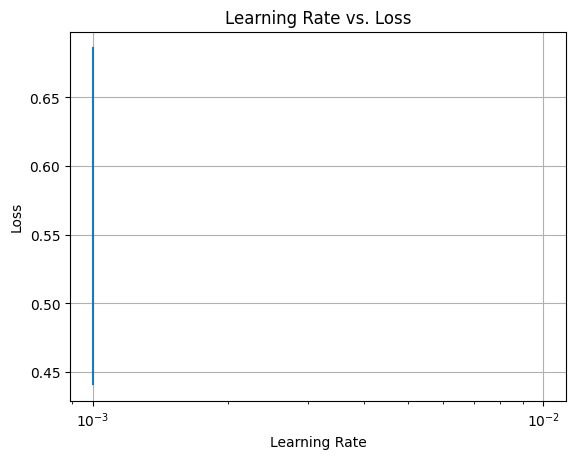

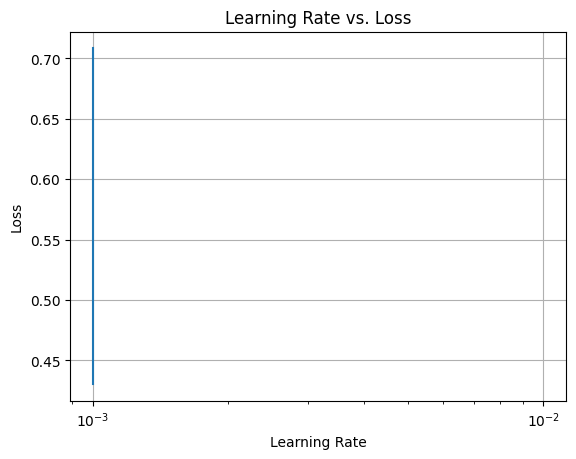

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to log learning rate and loss
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        self.learning_rates = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        loss = logs.get('loss')
        self.learning_rates.append(lr)
        self.losses.append(loss)

# Modified train_tensor function
def train_tensor(nbr_layers, nbr_neurals, activation, loss, optimizer, epoches, data, target_column, task_type, alpha=0.001):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    if task_type == 'classification':
        num_classes = len(y.unique())
        y = pd.get_dummies(y)  # One-hot encoding for classification
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    for i in range(nbr_layers):
        model.add(layers.Dense(units=nbr_neurals[i], activation=activation[i]))
    
    if task_type == 'regression':
        model.add(layers.Dense(1))  # Single output for regression
    elif task_type == 'classification':
        model.add(layers.Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification
    
    optimizer_func = getattr(tf.keras.optimizers, optimizer)(learning_rate=alpha)
    
    if task_type == 'regression':
        model.compile(loss=loss, optimizer=optimizer_func)
    elif task_type == 'classification':
        model.compile(loss='categorical_crossentropy', optimizer=optimizer_func, metrics=['accuracy'])

    # Initialize learning rate logger
    lr_logger = LearningRateLogger()
    
    history = model.fit(X_train, y_train, epochs=epoches, batch_size=32, validation_split=0.2, callbacks=[lr_logger])
    
    # Plot learning rate vs. loss
    plt.figure()
    plt.plot(lr_logger.learning_rates, lr_logger.losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.grid()
    plt.savefig('static/images/plots/lr_vs_loss.png')

    return model, history
train_tensor(
    nbr_layers=3,
    nbr_neurals=[64, 32, 16],
    activation=['relu', 'relu', 'relu'],
    loss='categorical_crossentropy',
    optimizer='Adam',
    epoches=10,
    data=data,
    target_column='Class',
    task_type='classification',
    alpha=0.001
)
import pandas as pd
from sklearn.datasets import make_classification

# Generate a sample dataset for classification
X, y = make_classification(n_samples=100, n_features=5, n_classes=2, random_state=42)

# Convert to DataFrame
data = pd.DataFrame(X, columns=[f'Feature{i}' for i in range(1, 6)])
data['Class'] = y  # Add target column 'Class'

# Save it to a CSV (optional if you want to test with a file)
data.to_csv('test_data.csv', index=False)
train_tensor(
    nbr_layers=3,
    nbr_neurals=[64, 32, 16],
    activation=['relu', 'relu', 'relu'],
    loss='categorical_crossentropy',
    optimizer='Adam',
    epoches=10,
    data=data,
    target_column='Class',
    task_type='classification',
    alpha=0.001
)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:4000
Press CTRL+C to quit
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/js/popper.min.js HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/images/item-background/item1.png HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/icon/icon.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/css/responsive.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/images/item-background/item8.png HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/css/swiper-bundle.min.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/css/shortcodes.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/images/item-background/item7.png HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:23:41] "GET /static/css/animation.css HTTP/1.1" 304

[10]


c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0298 - val_loss: 0.0244
Epoch 2/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 878us/step - loss: 0.0301 - val_loss: 0.0244
Epoch 3/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 877us/step - loss: 0.0296 - val_loss: 0.0244
Epoch 4/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 879us/step - loss: 0.0312 - val_loss: 0.0244
Epoch 5/5
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 896us/step - loss: 0.0304 - val_loss: 0.0244
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - loss: 0.0230
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 965 (3.77 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 644 (2.52 KB)

127.0.0.1 - - [21/Oct/2024 13:26:53] "POST /train_data HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Oct/2024 13:26:53] "POST /train_data HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/css/style.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/css/style.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/css/responsive.css HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/css/responsive.css HTTP/1.1" 304 -
127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/images/plots/model_loss_plot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/images/plots/model_loss_plot.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/images/plots/model_performance_plot.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /static/images/plots/model_performance_plot.png HTTP/1.1" 200 -
127.0.0.1 - - [21/Oct/2024 13:26:53] "GET /stati

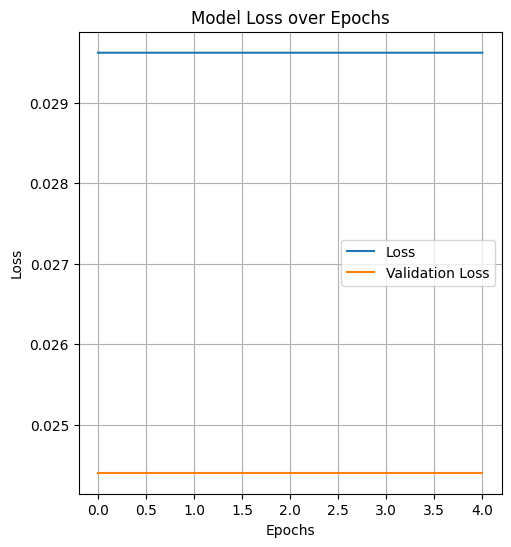

In [5]:
if __name__ == '__main__':
    app.run(debug=True,port=4000,use_reloader=False)